In [30]:
import polars as pl
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from datetime import datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from sklearn.decomposition import PCA
import dill as pickle
import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, SplineTransformer, KernelCenterer, PolynomialFeatures, PowerTransformer, QuantileTransformer, Normalizer
from itertools import chain
import math
from functools import partial
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [65]:
monthly_cases = pl.read_parquet('/home/tony/dengue/dengue_models/data/cases/agged/dengue_per_month.parquet')
monthly_params = pl.read_parquet('/home/tony/dengue/dengue_models/data/gee_exports/all_parameters_2001-01-01_2021-01-01_months.parquet')

monthly_params = monthly_params.with_columns((pl.col('start_date').str.to_date('%Y-%m-%d'),pl.col('end_date').str.to_date('%Y-%m-%d')))
monthly_cases = monthly_cases.with_columns(pl.col('ID_MUNICIP').str.slice(offset=0,length=6).cast(pl.Int64)).sort('DT_NOTIFIC').rename({
'DT_NOTIFIC': 'start_date',
'ID_MUNICIP': 'muni_id'
})

ALL_DATA = monthly_cases.join(monthly_params, how='left', on=['muni_id', 'start_date']).with_columns(pl.col('end_date').alias('month').dt.month())
TRAIN_START = '2005-01-01'
TRAIN_END = '2018-01-01'

TEST_START = '2018-01-01'
TEST_END = '2020-01-01'

EL = 12
LC = 24
binary_error = [np.array([-999.0, -999.0])]
ternary_error = [np.array([-999.0, -999.0, -999.0])]
SAVE_DIR = '/home/tony/dengue/dengue_models/results/'
SAVE_PREFIX = 'relative_binary_global'
CAT_STYLE = 'relative_binary_global'
CAT_FN = make_relative_ternary
ERROR_ARR = binary_error

In [5]:

def create_data_dict(start_date, 
                    end_date, 
                    all_data: pl.DataFrame, 
                    target_var = 'cases_per_100k',
                    case_lookback=24,
                    case_lag=1,
                    env_lag=0, 
                    env_lookback = 12,
                    env_list = [
                    'total_precipitation_sum', 
                    'temperature_2m', 
                    ],
                    additional_features = ['month', 'pop'],
                    return_dict = True
                    ):
    to_return = (
        all_data
        #.with_columns(pl.col('muni_id').alias('muni_cat'))
        .select(['muni_id', 'start_date', target_var] + env_list + additional_features)
        .filter((pl.col('start_date')>=datetime.fromisoformat(start_date)-relativedelta(years=math.ceil(case_lookback/12))) & (pl.col('start_date')<datetime.fromisoformat(end_date)))
        .with_columns(
            list(
                chain.from_iterable(
                    [
                        [pl.col(target_var).shift(i).over('muni_id').alias(f'{i}_shifted_cases')] for i in range(case_lag,case_lookback+case_lag)
                    ]
                    +
                    
                    [
                        [pl.col(e_var).shift(i).over('muni_id').alias(f'{i}_shifted_{e_var}') for i in range(env_lag,env_lookback+env_lag)] 
                            for e_var in env_list
                    ]
                    )
                )
        )
        .drop_nulls()
        .select(pl.exclude(env_list))
        .rename({target_var: 'target'})
    )

    return to_return if not return_dict else to_return.partition_by('muni_id', as_dict=True)

In [6]:
def get_features_for_muni(df, cat_fn=None, check_zeros=False):
    if check_zeros:
        if df.select(pl.col('target')).to_series().sum() == 0:
            return None
    selected = df if cat_fn is None else cat_fn(df)
    expectations = None
    #Some cat_fns return a tuple including expectations for category breaks based on historical data. If so, we want to pass these from training to testing data.
    if isinstance(selected, tuple):
        selected, expectations = selected
    target_key = 'target' if cat_fn is None else 'cat_target'
    target = selected.select(pl.col(target_key)).to_series().to_numpy().astype(float) 

    features = selected.select(pl.exclude(['muni_id', 'start_date', 'target', 'count', 'cat_target'])).to_numpy()
    dates = selected.select(pl.col('start_date')).to_series()
    muni_id = selected.select(pl.col('muni_id').first()).item()

    return {'X': features,
            'y': target,
            'dates': dates,
            'muni_id': muni_id,
            'expectations': expectations}

In [7]:
def handle_zero_case(muni_id):
    return pl.DataFrame({
        'predictions': [-999.0],
        'ground_truth': [-999.0],
        'date': [datetime.fromisoformat('1900-01-01')],
        'muni_id': [muni_id],
        'cat_style': ['NA'],
        'error': ['Only zeros in training data'],
        'probabilities': ERROR_ARR
    }).cast({'date':pl.Date})

In [9]:

def write_results(df: pl.DataFrame, save_dir, save_prefix, muni_id):
    #muni_id = df.select('muni_id').head(n=1).item()
    df.write_csv(os.path.join(save_dir, f'{muni_id}_{save_prefix}.csv'))

In [10]:
def make_simple_binary(df:pl.DataFrame):
    return df.with_columns(pl.col('target').cut([300], labels=['0','1']).alias('cat_target'))

In [11]:

def make_simple_ternary(df:pl.DataFrame):
    return df.with_columns(pl.col('target').cut([100,300], labels=['0','1', '2']).alias('cat_target'))

In [12]:

def make_relative_binary(df:pl.DataFrame, expectations=None):
    if expectations is None:
        #We can do this all as one statement with polars ofc but want to save training expectations so they can be applied to test data
        expectations = df.with_columns(pl.col('target').mean().over(['muni_id','month']).alias('expected')).group_by(['muni_id', 'month']).agg(pl.col('expected').first()).sort('month')

    return (
            (
                df
                .join(expectations, on=['muni_id', 'month'])
                .with_columns(
                    pl.when(pl.col('target')>pl.col('expected'))
                    .then(pl.lit('1'))
                    .otherwise(pl.lit('0'))
                    .alias('cat_target')
                    )
                .select(pl.exclude('expected'))
            ),
            expectations
    )

In [13]:


def make_relative_ternary(df:pl.DataFrame, expectations=None):
    if expectations is None:
        #We can do this all as one statement with polars ofc but want to save training expectations so they can be applied to test data
        expectations = df.with_columns(pl.col('target').mean().over(['muni_id', 'month']).alias('expected')).group_by(['muni_id', 'month']).agg(pl.col('expected').first()).sort('month')

    return (
            (
                df
                .join(expectations, on=['muni_id', 'month'])
                .with_columns(
                    pl.when(pl.col('target')<=pl.col('expected')*.5)
                    .then(pl.lit('0'))
                    .when((pl.col('target')>pl.col('expected')*.5)&(pl.col('target')<=pl.col('expected')))
                    .then(pl.lit('1'))
                    .otherwise(pl.lit('2'))
                    .alias('cat_target')
                    )
                .select(pl.exclude('expected'))
            ),
            expectations
    )


In [83]:

def train_global(train, cat_style='', train_transform=None, target_transform=None):

    #n_components = 15
    n_components = train['X'].shape[1]
    
    reg = HistGradientBoostingClassifier(
    random_state=42,
    categorical_features = [n_components-1],
    #l2_regularization=.05,
    #categorical_features=[15],
    max_iter=15000, 
    #learning_rate=0.5,
    #max_leaf_nodes=None, 
    #min_samples_leaf=10,
    #max_bins=255,
    early_stopping=True,
    class_weight='balanced',
    #validation_fraction=None
    )

    ct = ColumnTransformer([
        #('min_max', MinMaxScaler(), list(range(0, n_components-1))),
        ('min_max', RobustScaler(), list(range(1, n_components))),
    ],
    remainder='passthrough')

    train_x = ct.fit_transform(train['X'])
    if train_transform is not None:
        train_x = train_transform(train_x)
    #test_x = ct.transform(test['X'])

    train_y = train['y']
    if target_transform is not None:
        train_y = target_transform(train_y)

    #sample_weight = compute_sample_weight('balanced', train['y'])
    reg.fit(train_x, train_y, 
            #sample_weight=sample_weight
            )
    
    return reg, ct

In [15]:
def test_global(model, transformer, test, cat_style):
    test_x = transformer.transform(test['X'])

    z = model.predict(test_x)
    p_hat = model.predict_proba(test_x)
    return pl.DataFrame({
        'predictions': z,
        'ground_truth': test['y'],
        'date': test['dates'],
        'muni_id': [test['muni_id']]*len(z),
        'cat_style': [cat_style]*len(z),
        'error': ['NONE'] * len(z),
        'probabilities': p_hat
    })

In [82]:
def train_models(train_transform = None, target_transform = None):

    global_data = create_data_dict(TRAIN_START, TRAIN_END, ALL_DATA, env_list=[], return_dict=False)
    global_data = (
        global_data
        .with_columns(pl.col('target').sum().over('muni_id').alias('muni_sum'))
        #.filter(pl.col('muni_sum')!=0)
        #.select(pl.exclude('muni_sum'))
    )

    skip_munis = global_data.filter(pl.col('muni_sum') == 0).select('muni_id').unique().to_series()
    global_data = global_data.filter(pl.col('muni_sum')!=0).select(pl.exclude('muni_sum'))

    test_data= create_data_dict(TEST_START, TEST_END, ALL_DATA, env_list=[], return_dict=False)

    train_data = get_features_for_muni(global_data, CAT_FN, check_zeros=False)
    expectations = train_data['expectations']
    global_model, col_transformer = train_global(train_data,cat_style=CAT_STYLE, train_transform=train_transform, target_transform=target_transform)


    new_cat_fn = partial(CAT_FN, expectations = expectations)
    test_data = get_features_for_muni(test_data, new_cat_fn, check_zeros=False)



    results = test_global(global_model, col_transformer, test_data, CAT_STYLE)

    return results

In [92]:
predictions = train_models()

In [93]:
print(classification_report(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series()))

              precision    recall  f1-score   support

         0.0       0.90      0.71      0.80     90657
         1.0       0.16      0.58      0.25      7933
         2.0       0.61      0.57      0.59     30242

    accuracy                           0.67    128832
   macro avg       0.56      0.62      0.54    128832
weighted avg       0.79      0.67      0.71    128832



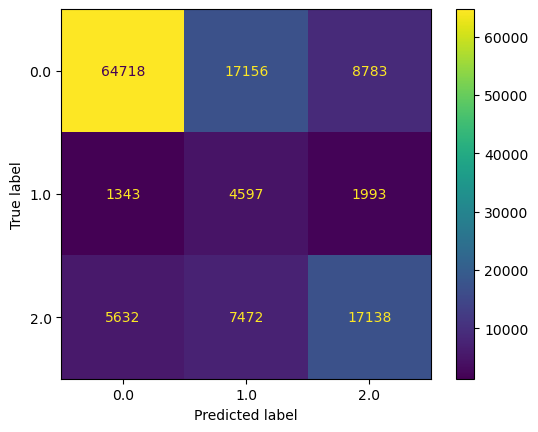

In [94]:
ConfusionMatrixDisplay.from_predictions(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series())

##Test 1: Random null training features
Results: Seems to increase accuracy on 1.0 category. Seems to indicate data has a ton of noise if 85% of training data can be x'ed out and still works

In [73]:
import numpy as np

def random_null(inp: np.array, p=0.25):
    rng = np.random.default_rng(12345)
    samples = rng.uniform(size=inp.shape)

    inp[samples<=p] = np.nan
    return inp


In [74]:
predictions = train_models(random_null)

In [75]:
print(classification_report(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series()))

              precision    recall  f1-score   support

         0.0       0.90      0.71      0.80     90657
         1.0       0.16      0.57      0.25      7933
         2.0       0.61      0.57      0.59     30242

    accuracy                           0.67    128832
   macro avg       0.56      0.62      0.54    128832
weighted avg       0.79      0.67      0.71    128832



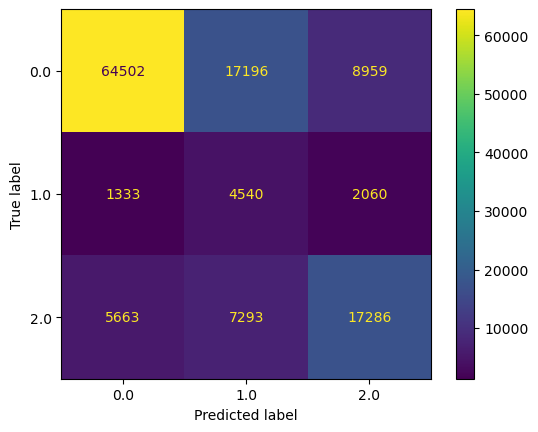

In [76]:
ConfusionMatrixDisplay.from_predictions(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series())

##Test 1: Additional random null training features

In [99]:
import numpy as np

def random_null_add(inp: np.array, p=0.25):
    rng = np.random.default_rng(12345)
    samples = rng.uniform(size=inp.shape)
    copied = np.copy(inp)
    copied[samples<=p] = np.nan
    return np.concatenate((inp, copied))

def training_double(inp: np.array):
    return np.concatenate((inp, inp))


In [100]:
predictions = train_models(train_transform=random_null_add, target_transform=training_double)

In [101]:
print(classification_report(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series()))

              precision    recall  f1-score   support

         0.0       0.90      0.75      0.81     90657
         1.0       0.16      0.46      0.24      7933
         2.0       0.59      0.60      0.60     30242

    accuracy                           0.70    128832
   macro avg       0.55      0.60      0.55    128832
weighted avg       0.78      0.70      0.73    128832



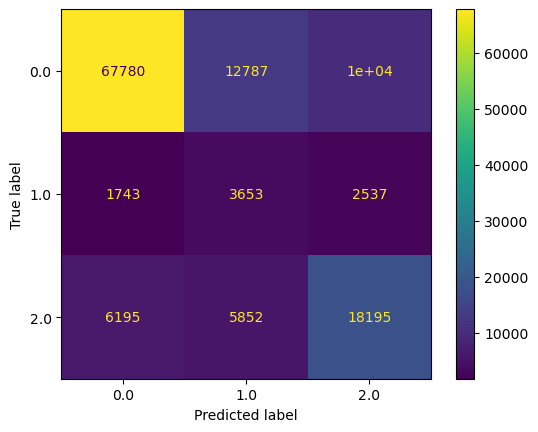

In [102]:
ConfusionMatrixDisplay.from_predictions(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series())